# Application of OT and POT: Color Transfer

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import numpy as np

## Create or load the experimental settings

In [2]:
import os
from color_transfer import setup_color_transfer
from scipy.io import loadmat

# Change the paths to these images
source_path = "color_transfer/data/windows7.jpg"
target_path = "color_transfer/data/kiwi_large.jpg"

In [3]:
source_rgb = img.imread(source_path)
target_rgb = img.imread(target_path)

## Display the images

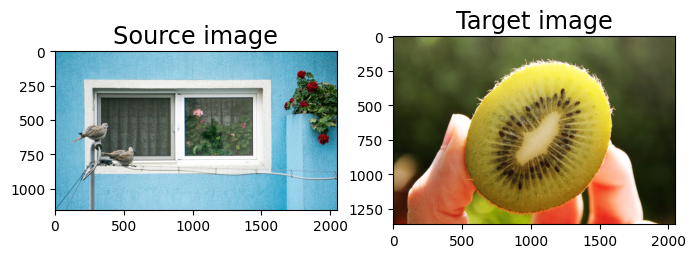

In [4]:
# Display these images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 20))
ax1.imshow(source_rgb)
ax1.set_title("Source image", size="xx-large")
ax2.imshow(target_rgb)
ax2.set_title("Target image", size="xx-large")
plt.show()

## Create marginal distributions

In [5]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [6]:
def color_quantize(img, n_colors):
    """ cluster all colors of image """
    shape = img.shape
    img = img.reshape(-1, 3)

    km = KMeans(n_clusters=n_colors, n_init=1, max_iter=300, random_state=100).fit(img)
    centers = km.cluster_centers_
    labels = km.labels_
    
    return shape, centers, labels

In [7]:
B = 100
source_shape, source_centers, source_labels = color_quantize(source_rgb, n_colors=B)
target_shape, target_centers, target_labels = color_quantize(target_rgb, n_colors=B)

In [8]:
source_hist = np.bincount(source_labels, minlength=B).astype(np.float64)
target_hist = np.bincount(target_labels, minlength=B).astype(np.float64)

In [9]:
max_mass = max(source_hist.sum(), target_hist.sum())
source_hist /= max_mass
target_hist /= max_mass

min_mass = min(source_hist.sum(), target_hist.sum())

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
C = euclidean_distances(source_centers, target_centers, squared=True)
C /= np.max(C)

### Plot the source and target histograms and the cost matrix

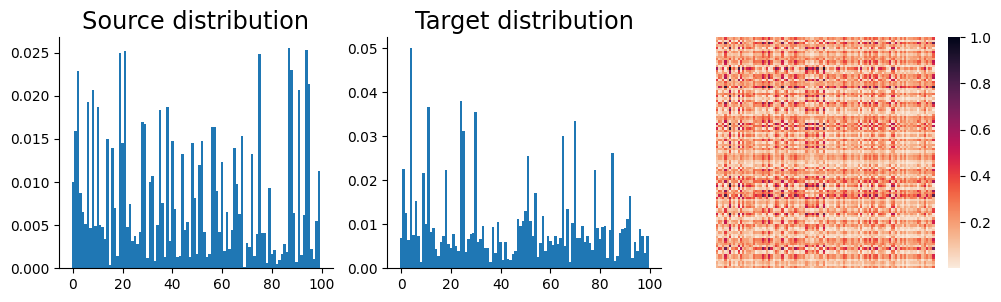

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# Plot source distribution
ax1.bar(np.arange(len(source_hist)), source_hist, width=1)
ax1.set_title("Source distribution", size="xx-large")
sns.despine(ax=ax1)

# Plot target distribution
ax2.bar(np.arange(len(target_hist)), target_hist, width=1)
ax2.set_title("Target distribution", size="xx-large")
sns.despine(ax=ax2)

# Plot cost matrix
sns.heatmap(C, cmap=sns.color_palette("rocket_r", as_cmap=True), ax=ax3)
ax3.set_xticks([]); ax3.set_yticks([])

plt.show()

In [49]:
from pot_solvers import lp
s = 0.1 * min_mass
X_lp = lp(source_hist, target_hist, C, s, tol=1e-15, verbose=False)
f_star = np.sum(X_lp * C)
f_star

0.00011104907053767905

## Run a (P)OT agorithm

In [54]:
from pot_solvers import sinkhorn, apdagd
T_apdagd, logs_apdagd = apdagd(source_hist.flatten(), target_hist.flatten(),
                               C, s=s, tol=1e-2, verbose=True, print_every=500,
                               check_termination=True, num_iters=2000,
                               # gamma=1e-3
                               )

T_sinkhorn, logs_sinkhorn = sinkhorn(source_hist.flatten(), target_hist.flatten(),
                                     C, s=s, tol=1e-2, verbose=True, print_every=500,
                                     check_termination=True, num_iters=2000,
                                     # gamma=1e-3
                                     )

Regularization parameter: gamma = 5.43e-04
Tolerance for duality gap        : 6.25e-04
Tolerance for ||X1 + p - a||_2   : 6.25e-04
Tolerance for ||X.T 1 + q - b||_2: 6.25e-04
Tolerance for ||1.T X 1 - s||_2  : 6.25e-04
APDAGD converged after 162 iterations
Regularization parameter: gamma = 5.42e-04
Sinkhorn tolerance      : tol   = 5.68e-04
Sinkhorn converged after 169 iterations


In [55]:
X_sinkhorn = logs_sinkhorn["transport_matrix"]
X_apdagd = logs_apdagd["transport_matrix"]

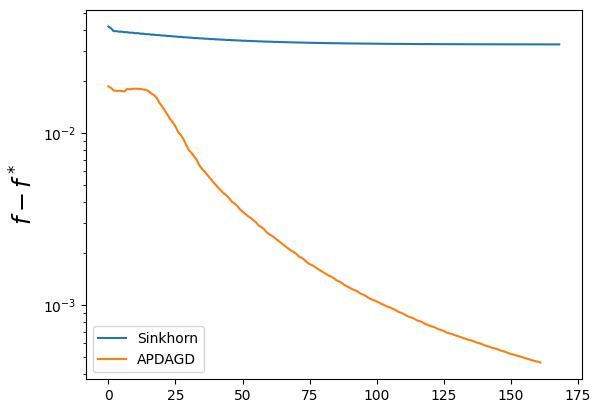

In [56]:
plt.plot([np.sum(C * X) -  f_star for X in X_sinkhorn], label="Sinkhorn")
plt.plot([np.sum(C * X) -  f_star for X in X_apdagd], label="APDAGD")
plt.legend()
plt.yscale("log")
# plt.xscale("log")
plt.ylabel("$f- f^*$", size="xx-large")
plt.show()

In [34]:
# plt.plot([abs(np.sum(X) - s) for X in X_sinkhorn], label="Sinkhorn")
# plt.plot([abs(np.sum(X) - s) for X in X_apdagd], label="APDAGD")
# plt.yscale("log")
# plt.ylabel("$1^\\top X 1 - s$", size="xx-large")
# plt.legend()
# plt.show()

## Apply transport matrix to source image

In [35]:
def apply_transport(X, 
                    source_centers, source_labels, soure_shape,
                    target_centers, target_labels, target_shape):

    def map_img(T, img1, img2, weights1):
        """Transfer colors from img2 to img1"""
        return np.dot(T / (1e-7 + weights1[:, np.newaxis]), img2)

    source_img = source_centers[source_labels]
    target_img = target_centers[target_labels]

    source_centers_mapped = map_img(X, source_centers, target_centers, X.sum(1))
    source_img_mapped = source_centers_mapped[source_labels]
    source_img_mapped = source_img_mapped.reshape(source_shape)

    target_centers_mapped = map_img(X.T, target_centers, source_centers, X.sum(0))
    target_img_mapped = target_centers_mapped[target_labels]
    target_img_mapped = target_img_mapped.reshape(target_shape)
    
    return source_img_mapped

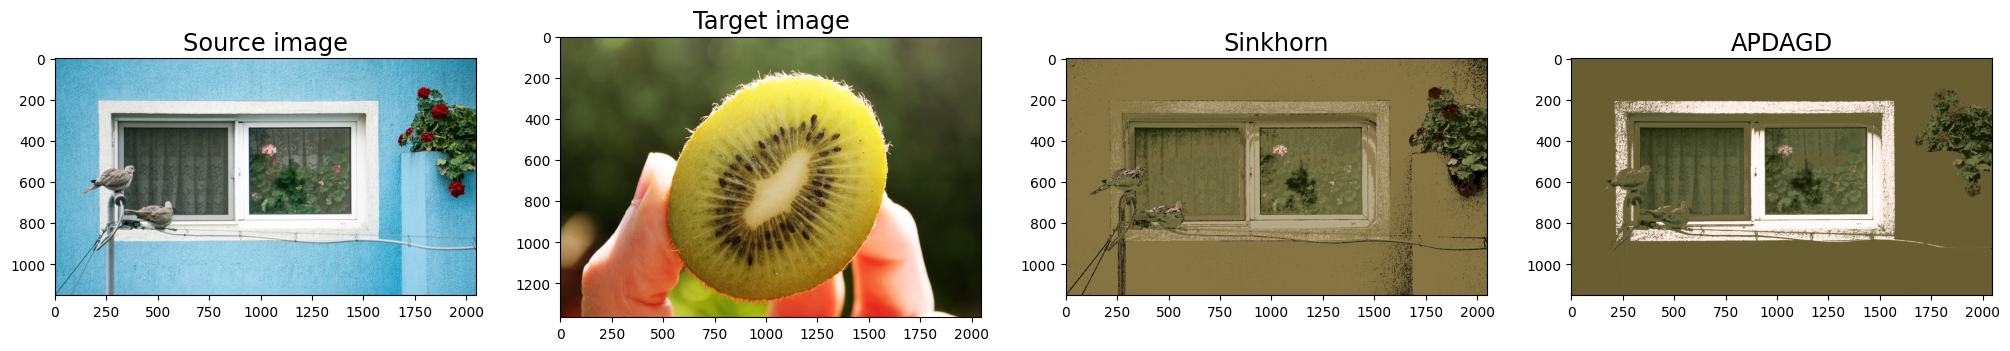

In [57]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 50))
ax1.imshow(source_rgb)
ax1.set_title("Source image", size="xx-large")

ax2.imshow(target_rgb)
ax2.set_title("Target image", size="xx-large")

T = T_sinkhorn
source_mapped = apply_transport(T_sinkhorn, 
                                source_centers, source_labels, source_shape,
                                target_centers, target_labels, target_shape,
                                )
ax3.imshow(source_mapped / 255)
ax3.set_title("Sinkhorn", size="xx-large")

T_sinkhorn_plot = source_mapped.copy()

# T = T_apdagd
# cY, nY_apdagd = apply_transport(T, Y=source_rgb, luvY=source_luv)
source_mapped = apply_transport(T_apdagd, 
                                source_centers, source_labels, source_shape,
                                target_centers, target_labels, target_shape,
                                )
ax4.imshow(source_mapped / 255)
ax4.set_title("APDAGD", size="xx-large")

T_apdagd_plot = source_mapped.copy()


plt.show()

In [38]:
from tqdm import tqdm
s_range = [0.1, 0.5, 0.7, 0.9, 0.99]
solutions = []
for i, s in tqdm(enumerate(s_range)):
    T_apdagd, _ = apdagd(source_hist.flatten(), target_hist.flatten(),
                         C, s=s * min_mass, tol=1e-2, verbose=False,
                         check_termination=False, num_iters=1000,
                         # gamma=1e-3, 
                         save_iterates=False)
    # cY, nY_apdagd = apply_transport(T_apdagd, Y=source_rgb, luvY=source_luv)
    nY_apdagd = apply_transport(T_apdagd, 
                                source_centers, source_labels, source_shape,
                                target_centers, target_labels, target_shape,
                                )
    solutions.append(nY_apdagd / 255)

5it [00:08,  1.76s/it]


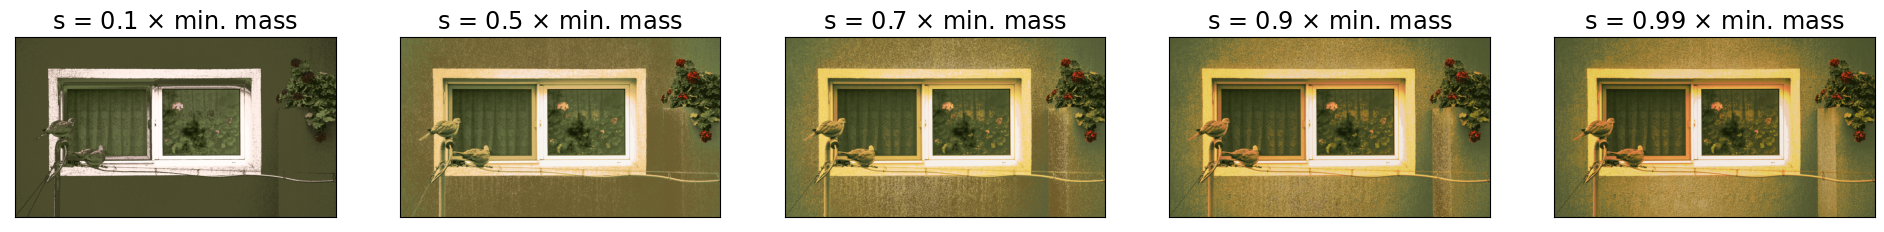

In [39]:
fig, axes = plt.subplots(1, 5, figsize=(24, 10))
for ax, sol, s in zip(axes, solutions, s_range):
    ax.imshow(sol)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"s = {s} $\\times$ min. mass", size="xx-large")
plt.savefig("figures/whitehouse_to_balloon.jpg")

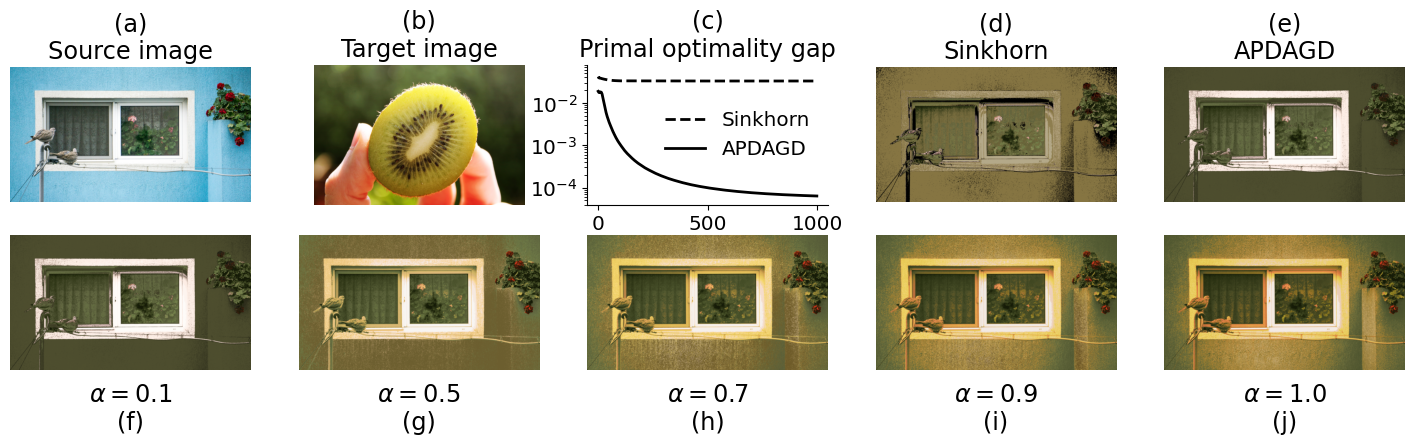

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(18, 4))

ax = axes[0,0]
ax.imshow(source_rgb)
ax.set_title("(a)\nSource image", size="xx-large")
ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()

ax = axes[0,1]
ax.imshow(target_rgb)
ax.set_title("(b)\nTarget image", size="xx-large")
ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()

ax = axes[0,2]
ax.plot([np.sum(C * X) -  f_star for X in X_sinkhorn], 
        color="black", linestyle="dashed", linewidth=2, label="Sinkhorn")
ax.plot([np.sum(C * X) -  f_star for X in X_apdagd], 
        color="black", linestyle="solid", linewidth=2, label="APDAGD")
ax.legend(prop={'size': "x-large"}, frameon=False)
ax.set_yscale("log")
ax.set_title("(c)\nPrimal optimality gap", size="xx-large")
ax.set_ylim([4e-5, 8e-2])
ax.tick_params(axis='x', which='major', labelsize="x-large")
ax.tick_params(axis='y', which='major', labelsize="x-large")
sns.despine(ax=ax)

ax = axes[0,3]
ax.imshow(T_sinkhorn_plot / 255)
ax.set_title("(d)\nSinkhorn", size="xx-large")
ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()

ax = axes[0,4]
ax.imshow(T_apdagd_plot / 255)
ax.set_title("(e)\nAPDAGD", size="xx-large")
ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()

for ax, sol, s, subfig_index in zip(axes[1,:], solutions, s_range, "fghij"):
    ax.imshow(sol)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
    ax.set_title(f"$\\alpha = {s:.1f}$\n({subfig_index})", size="xx-large", y=-0.15, va="top")

plt.savefig("figures/color_transfer_all.pdf", bbox_inches="tight")

plt.show()

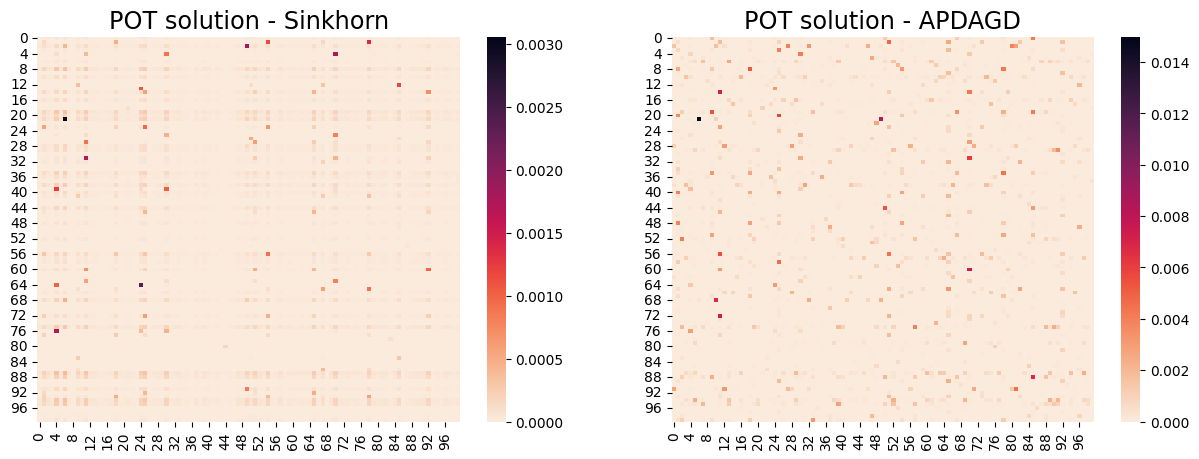

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(T_sinkhorn, ax=ax1, cmap=sns.color_palette("rocket_r", as_cmap=True))
ax1.set_title("POT solution - Sinkhorn", size="xx-large")
sns.heatmap(T_apdagd, ax=ax2, cmap=sns.color_palette("rocket_r", as_cmap=True))
ax2.set_title("POT solution - APDAGD", size="xx-large")
plt.show()